In [1]:
import sys,os, time

#SET gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 


from prediction_imports import *
from imports import *
import matplotlib.pyplot as plt

Version:  2.3.2
Eager mode:  True
Version:  2.3.2
Eager mode:  True
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [5]:
#GET THE CONFIG
configfile = "../data/CTNOAA_minorAUG.json"
with open(configfile) as f:
    config = json.load(f)

for k in config.keys():
    exec(k+'=config["'+k+'"]')


In [3]:
model =  custom_resunet((TARGET_SIZE[0], TARGET_SIZE[1], N_DATA_BANDS),
                        FILTERS,
                        nclasses=[NCLASSES+1 if NCLASSES==1 else NCLASSES][0],
                        kernel_size=(KERNEL,KERNEL),
                        strides=STRIDE,
                        dropout=DROPOUT,#0.1,
                        dropout_change_per_layer=DROPOUT_CHANGE_PER_LAYER,#0.0,
                        dropout_type=DROPOUT_TYPE,#"standard",
                        use_dropout_on_upsampling=USE_DROPOUT_ON_UPSAMPLING,#False,
                        )



In [6]:
#model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [mean_iou, dice_coef])

# get the weights
weights = "../data/CTNOAA_minorAUG.h5"
model.load_weights(weights)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 1024, 7) 91          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768, 1024, 7) 28          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 1024, 7) 28          input_1[0][0]                    
_______________________________________________________________________________________

In [8]:
#define directory of images
pred_dir = "../data/toPredict/img"

#load images for wash
w_test = []
w_images = []
for img in os.listdir(pred_dir):
    #pull the name of the image
    w_images.append(img)
    #pull the image
    img = os.path.join(pred_dir, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = (TARGET_SIZE[0], TARGET_SIZE[1]))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img =  standardize(img)
    img = np.expand_dims(img,axis=0)
    w_test.append(img)

#make predictions 
w_test = np.vstack(w_test)
w_preds = model.predict(w_test)

In [9]:
#this is the 4 class predictionon, and 3 images in the directory
w_preds.shape

(3, 768, 1024, 4)

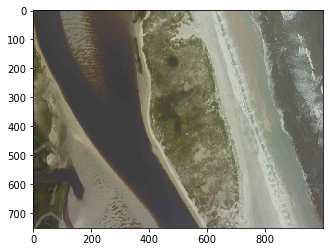

In [11]:
img = matplotlib.image.imread("../data/toPredict/img/C26047791-3_EBG.jpg")
imgplot = plt.imshow(img)

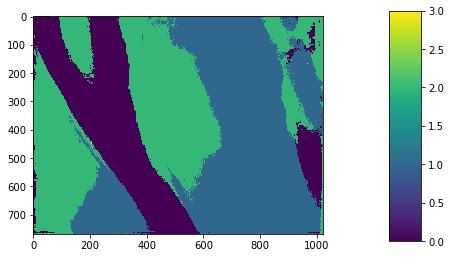

In [12]:
#these are the actual indicies, thes classes (whcih we get with argmax)
am_input = w_preds[2,:,:,:].squeeze()
lab = np.argmax(am_input,-1)

# plot the fig where water: 0; sand:1; veg : 2; dev : 3

plt.imshow(lab)
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

(768, 1024, 4)


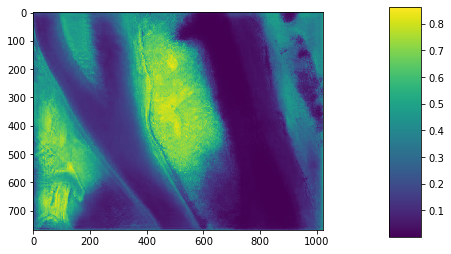

In [13]:
#now, look at the softmax scores for the first image
sqpred = w_preds[2,:,:,:]
print(sqpred.shape)

#we can look at the softmax scores for each class (water: 0; sand:1; veg : 2; dev : 3) 
SL_pred = sqpred[:,:,2]

#SL_pred.shape
plt.imshow(SL_pred)
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [14]:
# now the next goal is to find the top 2 predictions at each pixel
# we use sort for that
sortedPreds = np.sort(sqpred)
TopPred = sortedPreds[:,:,3]
SecondPred = sortedPreds[:,:,2]

LConfidence = 1 - TopPred
Margin = (TopPred - SecondPred)

#the worst pred will have a largest Least Confidence
print(LConfidence.mean())
#the worst pred will have a smallest Margin
print(Margin.mean())

0.34652266
0.47574773


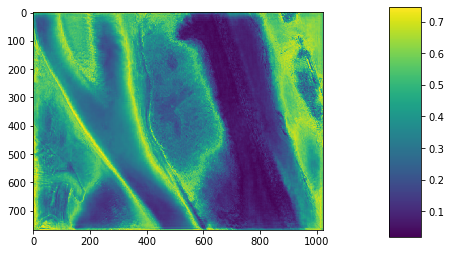

In [15]:
#Look at the least confident predictions from the model.. 
plt.imshow(LConfidence)

cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

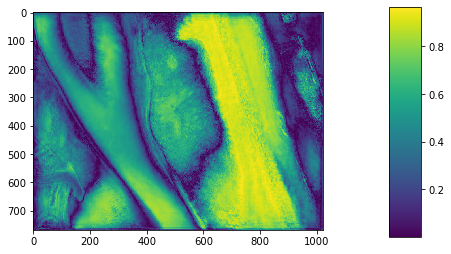

In [16]:
#and now we can look at the margins between class predictions

plt.imshow(Margin)

cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [29]:
#the next steps for active learnign are to feed many images into the model (with a generator) 
# and then rank them based on confidence and margin.